In [1]:
import os
import matplotlib.pyplot as pit
from nilearn.image import mean_img,load_img
from nilearn.plotting import plot_stat_map, plot_anat, plot_img,show, plot_glass_brain
from bids.layout import BIDSLayout
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
#base directory
fmriprep_dir='Full-Dataset'
layout=BIDSLayout(fmriprep_dir)

In [3]:
anat_img=layout.get(subject='01',datatype='anat',extension='.nii.gz',return_type="file")
fmri_img_normal=layout.get(subject='01',datatype='func',extension='.nii.gz',return_type="file")
fmri_img_affected=layout.get(subject='60',datatype='func',extension='.nii.gz',return_type="file")

In [4]:
print(anat_img)

["c:\\Reuben's Code's\\PyTorch\\DataSet Testing\\Full-Dataset\\sub-01\\anat\\sub-01_T1w.nii.gz"]


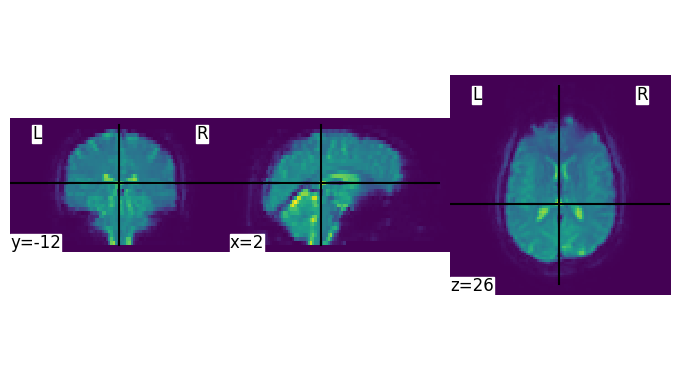

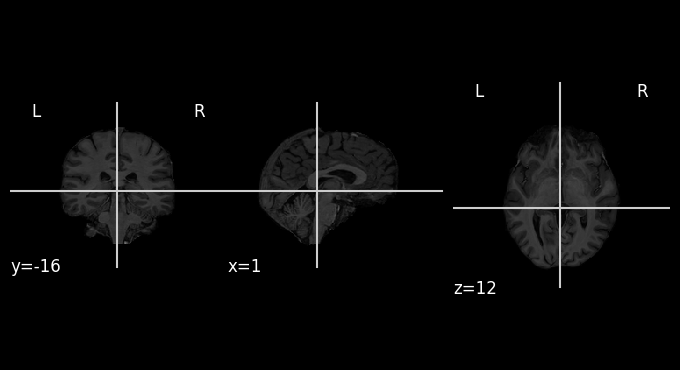

In [14]:
mean_img = mean_img(fmri_img_normal)
plot_img(mean_img)
t1_image=load_img(anat_img)
plot_anat(t1_image)


In [6]:
events=pd.read_table('Full-Dataset\\task-speech_events.tsv')
print(events)

    onset  duration   trial_type
0       0        26  white-noise
1      28        26    sentences
2      56        26        words
3      84        26     reversed
4     112        26  white-noise
5     140        26        words
6     168        26     reversed
7     196        26    sentences
8     224        26  white-noise
9     252        26     reversed
10    280        26    sentences
11    308        26        words
12    336        26  white-noise
13    364        26    sentences
14    392        26     reversed
15    420        26        words
16    448        26  white-noise
17    476        26     reversed
18    504        26        words
19    532        26    sentences
20    560        26  white-noise
21    588        26        words
22    616        26    sentences
23    644        26     reversed


In [7]:
from nilearn.glm.first_level import FirstLevelModel
FirstLevelModel?

Init signature:
FirstLevelModel(
    t_r=None,
    slice_time_ref=0.0,
    hrf_model='glover',
    drift_model='cosine',
    high_pass=0.01,
    drift_order=1,
    fir_delays=[0],
    min_onset=-24,
    mask_img=None,
    target_affine=None,
    target_shape=None,
    smoothing_fwhm=None,
    memory=Memory(location=None),
    memory_level=1,
    standardize=False,
    signal_scaling=0,
    noise_model='ar1',
    verbose=0,
    n_jobs=1,
    minimize_memory=True,
    subject_label=None,
    random_state=None,
)
Docstring:     
Implement the General Linear Model for single session fMRI data.

Parameters
----------
t_r : float
    This parameter indicates repetition times of the experimental runs.
    In seconds. It is necessary to correctly consider times in the design
    matrix. This parameter is also passed to :func:`nilearn.signal.clean`.
    Please see the related documentation for details.

slice_time_ref : float, optional
    This parameter indicates the time of the reference slic

In [10]:
!nib-ls Full-Dataset\sub-01\func\sub-01_task-speech_bold.nii.gz

Full-Dataset\sub-01\func\sub-01_task-speech_bold.nii.gz float32 [ 96,  96,  32, 341] 2.50x2.50x4.25x2.00   sform



In [11]:
fmri_glm = FirstLevelModel(t_r=2,
                           noise_model='ar1',
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=1./160,
                           signal_scaling=False,
                           minimize_memory=False)

In [16]:
fmri_glm = fmri_glm.fit(fmri_img_normal, events)

In [17]:
design_matrix = fmri_glm.design_matrices_[0]

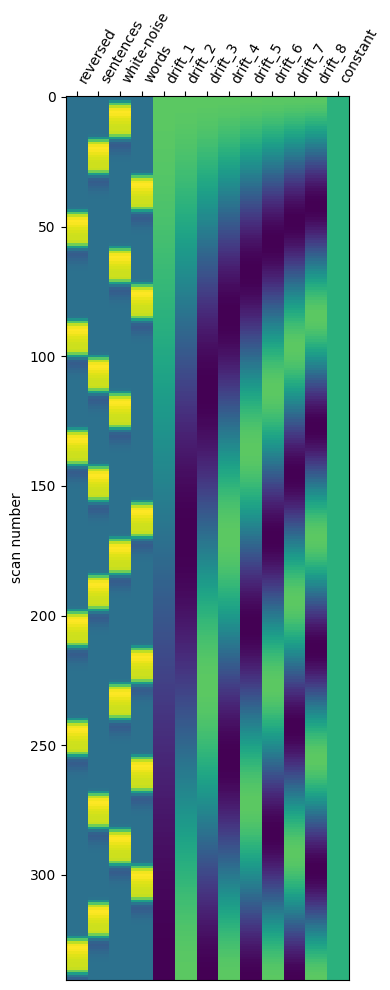

In [18]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

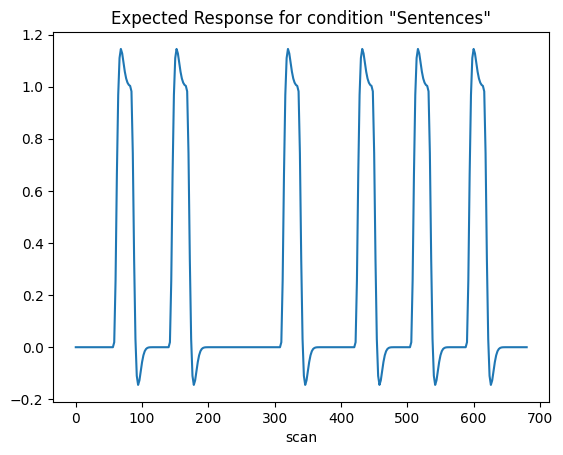

In [19]:
plt.plot(design_matrix['words'])
# plt.plot(design_matrix['reversed'])
# plt.plot(design_matrix['sentences'])
# plt.plot(design_matrix['white-noise'])
plt.xlabel('scan')
plt.title('Expected Response for condition "Sentences"')
plt.show()

In [20]:
conditions = {
    'active - Reversed': np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'active - Sentences':   np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'active - White-Noise':   np.array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'active - Words':   np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
}

<Axes: label='conditions'>

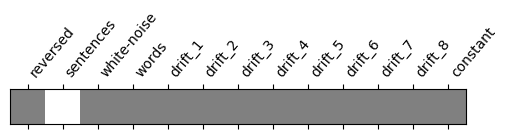

In [21]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(conditions['active - Sentences'], design_matrix=design_matrix)

In [22]:
eff_map = fmri_glm.compute_contrast(conditions['active - Sentences'],
                                    output_type='effect_size')

In [23]:
z_map = fmri_glm.compute_contrast(conditions['active - Sentences'],
                                  output_type='z_score')

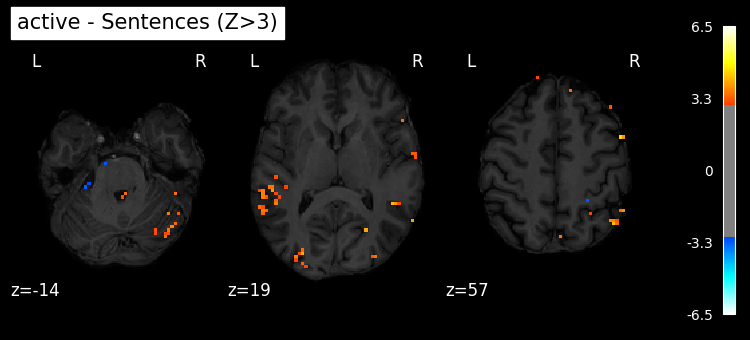

In [24]:
plot_stat_map(z_map, bg_img=t1_image, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active - Sentences (Z>3)')
plt.show()

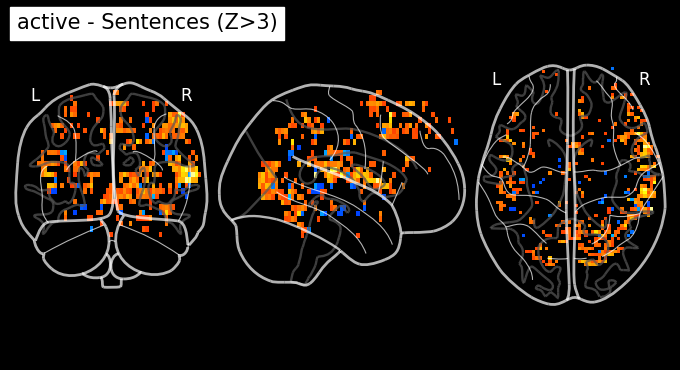

In [25]:
plot_glass_brain(z_map, threshold=3.0, black_bg=True, plot_abs=False,
                 title='active - Sentences (Z>3)')
plt.show()

Uncorrected p<0.001 threshold: 3.291


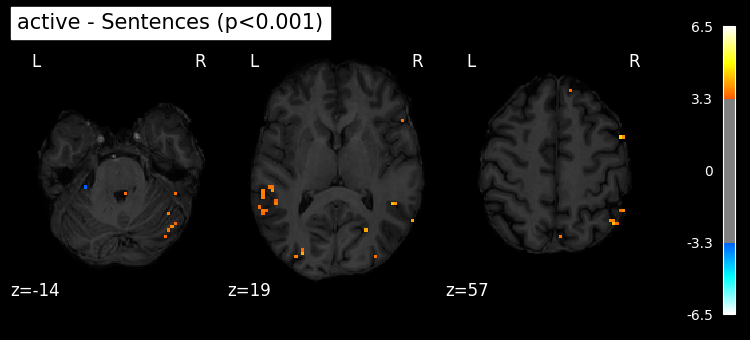

In [26]:
from nilearn.glm.thresholding import threshold_stats_img
_, threshold = threshold_stats_img(z_map, alpha=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=t1_image, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active - Sentences (p<0.001)')
plt.show()

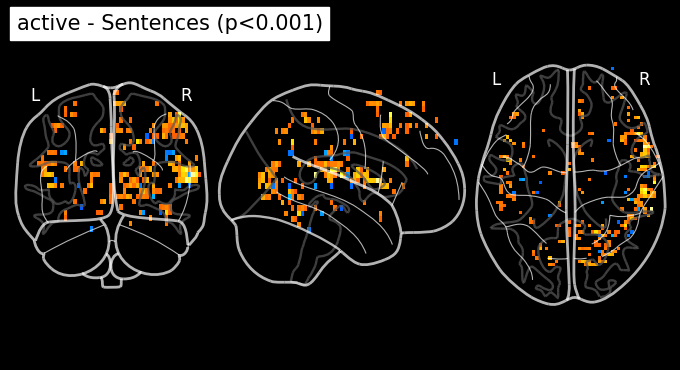

In [27]:
plot_glass_brain(z_map, threshold=threshold, black_bg=True, plot_abs=False,
                 title='active - Sentences (p<0.001)')
plt.show()

Bonferroni-corrected, p<0.05 threshold: 4.868


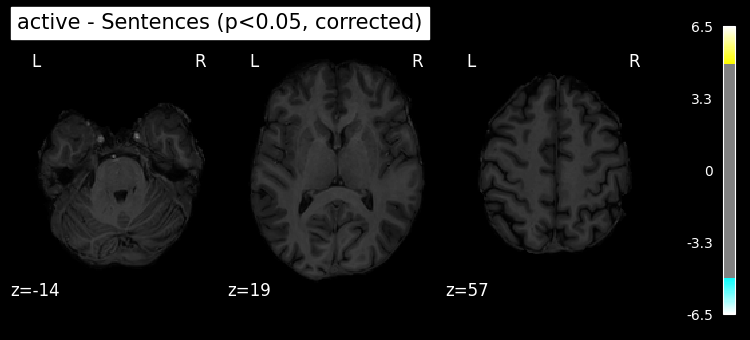

In [28]:
_, threshold = threshold_stats_img(z_map, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=t1_image, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='active - Sentences (p<0.05, corrected)')
plt.show()

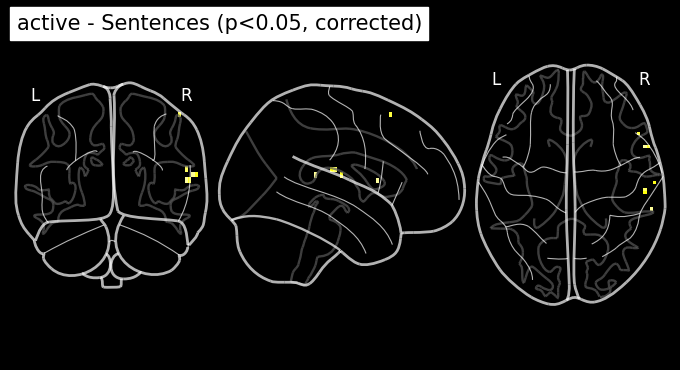

In [29]:
plot_glass_brain(z_map, threshold=threshold, black_bg=True, plot_abs=False,
                 title='active - Sentences (p<0.05, corrected)')
plt.show()